In [1]:
import numpy as np 
import pandas as pd 
import os
from torchvision import transforms, utils, models, datasets


import torch, random, copy
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import plotly.express as pe
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from utils.engine import train_one_epoch, evaluate
from utils import utils

# Train

In [2]:
def imshow(img_pt, trues, preds=None):
    img = F.to_pil_image(img_pt)
    size = img.size
    fig = pe.imshow(img)
    for box, label_list in zip(trues["boxes"],trues["labels"]):
        label_text = classes[label_list]
        fig.add_shape(type='rect',
                      x0=box[0], x1=box[2], 
                      y0=box[1], y1=box[3],
                      xref='x', yref='y',
                      line=dict(color='green', width=2))
        fig.add_annotation(x=box[0], y=box[1], text=str(classes[label_list.item()]),
                           xref="x", yref="y", showarrow=False,
                           font_size=10, font_color='green',
                           bgcolor="white")
    if preds != None:
        for box, label_list, score in zip(preds["boxes"].cpu().tolist(), preds["labels"].cpu().tolist(), preds["scores"].cpu().tolist(),):
            label_text = classes[label_list]
            fig.add_shape(type='rect',
                          x0=box[0], x1=box[2], 
                          y0=box[1], y1=box[3],
                          xref='x', yref='y',
                          line=dict(color='red', width=2, dash='dot'))
            fig.add_annotation(x=box[2], y=box[1], text=f"{classes[label_list]} {score*100:.1f}%",
                               xref="x", yref="y", showarrow=False,
                               font_size=10, font_color='red',
                               bgcolor="white")    
    fig.show()

In [20]:
compose = transforms.Compose([transforms.PILToTensor(),
                                transforms.ConvertImageDtype(torch.float),
                                transforms.RandomHorizontalFlip(0.5)])
def voc_transform_ing(img):
    
    target_anno = img["annotation"]
    w, h, d = list(map(int, target_anno['size'].values()))

    target = {"boxes":[], "labels":[],'area':[]}
    for obj in target_anno['object']:
        box = list(map(int,obj['bndbox'].values()))
        target["boxes"].append(box)
        target['labels'].append(classes.index(obj["name"]))
        
        area = (box[3] - box[1]) * (box[2] - box[0])
        target["area"].append(area)    

    iscrowd = torch.zeros((len(target["boxes"]),), dtype=torch.int64)

    target["image_id"] = torch.Tensor([int(target_anno['filename'][:-4])])
    target["boxes"] = torch.FloatTensor(target["boxes"])
    target["labels"] = torch.LongTensor(target["labels"])
    target["area"] = torch.FloatTensor(target["area"])
    target["iscrowd"] = iscrowd
    target["masks"] = torch.zeros((len(target["boxes"]),w, h), dtype=torch.float32)

    return target

In [21]:
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 
           'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 
           'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


path_dir_trainval = "../hw4_dataset/VOCTrainVal"
path_dir_test = "../hw4_dataset/VOCtest"

voctrainval_ds = datasets.VOCDetection(root=path_dir_trainval, year="2007", image_set="trainval", transform=compose, target_transform=voc_transform_ing)
voctest_ds = datasets.VOCDetection(root=path_dir_test, year="2007", image_set="test", transform=compose,target_transform=voc_transform_ing)

In [22]:
print(f"trainval dataset :{len(voctrainval_ds)} images")
print(f"test dataset :{len(voctest_ds)} images")
print(f"the meta data in image:{voctrainval_ds[0][1].keys()}")

trainval dataset :5011 images
test dataset :4952 images
the meta data in image:dict_keys(['boxes', 'labels', 'area', 'image_id', 'iscrowd', 'masks'])



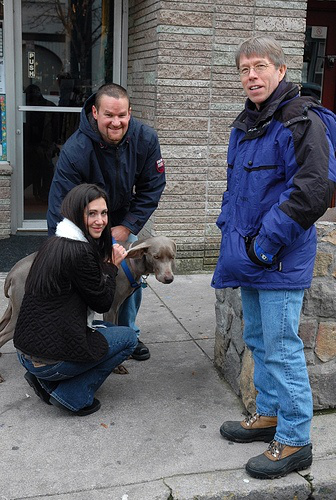

In [23]:
img_id = 8
imshow(voctrainval_ds[img_id][0], voctrainval_ds[img_id][1])

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

lr = 0.001
batch_size = 8
weight_decay=1e-5
num_classes = len(classes)
model = get_model_instance_segmentation(num_classes).to(device)
#model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(score_thresh=0.5, weights_backbone=True, num_classes=num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr = lr, weight_decay=weight_decay)


In [ ]:
train_ds = DataLoader(voctrainval_ds, batch_size=batch_size, collate_fn = utils.collate_fn, shuffle=True)
test_ds = DataLoader(voctest_ds, batch_size=batch_size, collate_fn = utils.collate_fn, shuffle=True)

num_epochs = 10

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

for epoch in range(num_epochs):
    metric_logger = train_one_epoch(model, optimizer, train_ds, device, epoch=epoch, print_freq=10, scaler=None)
    lr_scheduler.step()
        # evaluate on the test dataset3
    evaluate(model, test_ds, device=device)